In [79]:
import tensorflow as tf 
import tensorflow_io as tfio
import tensorflow_probability as tfp

print(tf.__version__)
print('Listing all GPU resources:')
print(tf.config.experimental.list_physical_devices('GPU'))
print()
import tensorflow.keras as keras
print(tfp.__version__)
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import os
from tqdm import trange
import sys
import git
import importlib

mpl.rcParams['image.cmap'] = 'coolwarm'

2.2.0
Listing all GPU resources:
[]

0.9.0


In [8]:
LAYER_NAME = 'encoder_1a'

FILTERS = 32
DATA_SIZE = 60000
PRIOR_MU = 0
PRIOR_SIGMA = 10

BATCH_SIZE = 128
EPOCHS = 200
VERBOSE = 2

N_PREDICTIONS = 100

ROOT_PATH = git.Repo("", search_parent_directories=True).git.rev_parse("--show-toplevel")
DATA_PATH = ROOT_PATH + "/data/"
LAYER_PATH = ROOT_PATH + "/layers/" + LAYER_NAME + "/"
SAVE_PATH = LAYER_PATH + LAYER_NAME + "_bayesian_model.h5"
PICKLE_PATH = LAYER_PATH + LAYER_NAME + '_hist.pkl'
MODEL_PATH = LAYER_PATH + LAYER_NAME + "_model"
IMAGE_PATH = ROOT_PATH + "/images/" + LAYER_NAME + "/"

In [9]:
print("-" * 30)
print("Constructing model...")
print("-" * 30)
spec = importlib.util.spec_from_file_location(MODEL_PATH, MODEL_PATH + ".py")
ModelLoader = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ModelLoader)
model = ModelLoader.make_model()
print(model.summary())

------------------------------
Constructing model...
------------------------------

Input size: (None, 144, 144, 4)
Output size: (None, 144, 144, 1)
Model: "model_encoder_1a"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 144, 144, 4) 0                                            
__________________________________________________________________________________________________
encoder_1_a (Conv2DFlipout)     (None, 144, 144, 32) 4736        input_layer[0][0]                
__________________________________________________________________________________________________
encoder_1_b (Conv2D)            (None, 144, 144, 32) 9248        encoder_1_a[0][0]                
__________________________________________________________________________________________________
downsample_1 (MaxPooling2D)     

In [10]:
model.load_weights(SAVE_PATH)
print("Model weights loaded successfully\n")

Model weights loaded successfully



In [11]:
n_test = 200
msks_test = np.load(DATA_PATH + 'msks_test.npy')[:n_test]
imgs_test = np.load(DATA_PATH + 'imgs_test.npy')[:n_test]

print("First " + str(n_test) + " test samples loaded\n")

First 200 test samples loaded



In [12]:
Xy_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(imgs_test),
                                tf.data.Dataset.from_tensor_slices(msks_test))
                             ).cache().batch(BATCH_SIZE).prefetch(8)

In [13]:
prediction_size = list(msks_test.shape)
prediction_size.insert(0, N_PREDICTIONS)
prediction_test = np.zeros(prediction_size)

In [14]:
print("Getting Monte Carlo samples of test predictions...")
for i in trange(N_PREDICTIONS):
    prediction_test[i] = model.predict(Xy_test)

  0%|          | 0/100 [00:00<?, ?it/s]

Getting Monte Carlo samples of test predictions...


100%|██████████| 100/100 [13:34<00:00,  8.41s/it]



 60%|██████    | 6/10 [00:34<00:22,  5.70s/it]/Users/hauthj/miniconda3/envs/test-env/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

 70%|███████   | 7/10 [00:39<00:17,  5.73s/it]/Users/hauthj/miniconda3/envs/test-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/Users/hauthj/miniconda3/envs/test-env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pypl

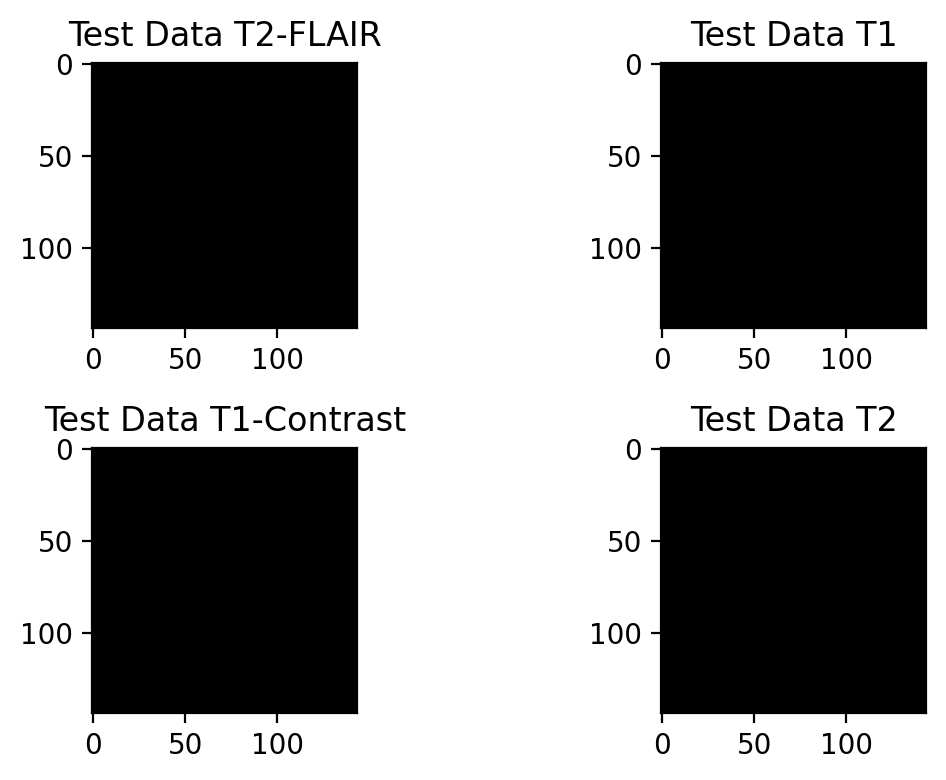

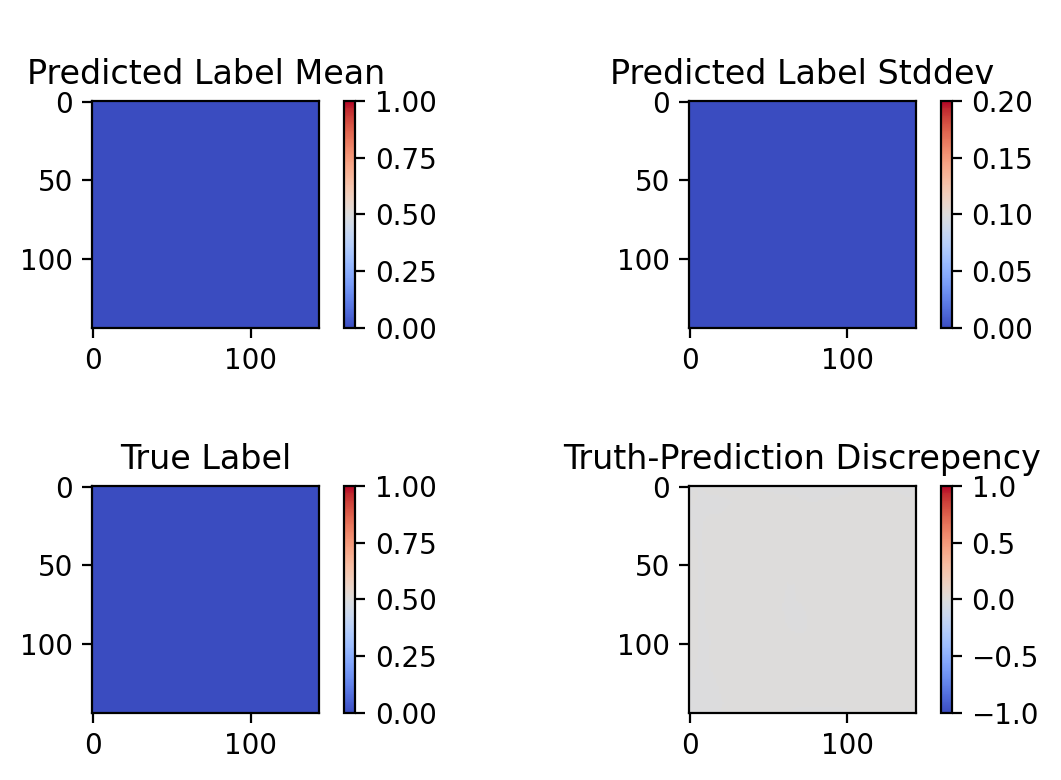

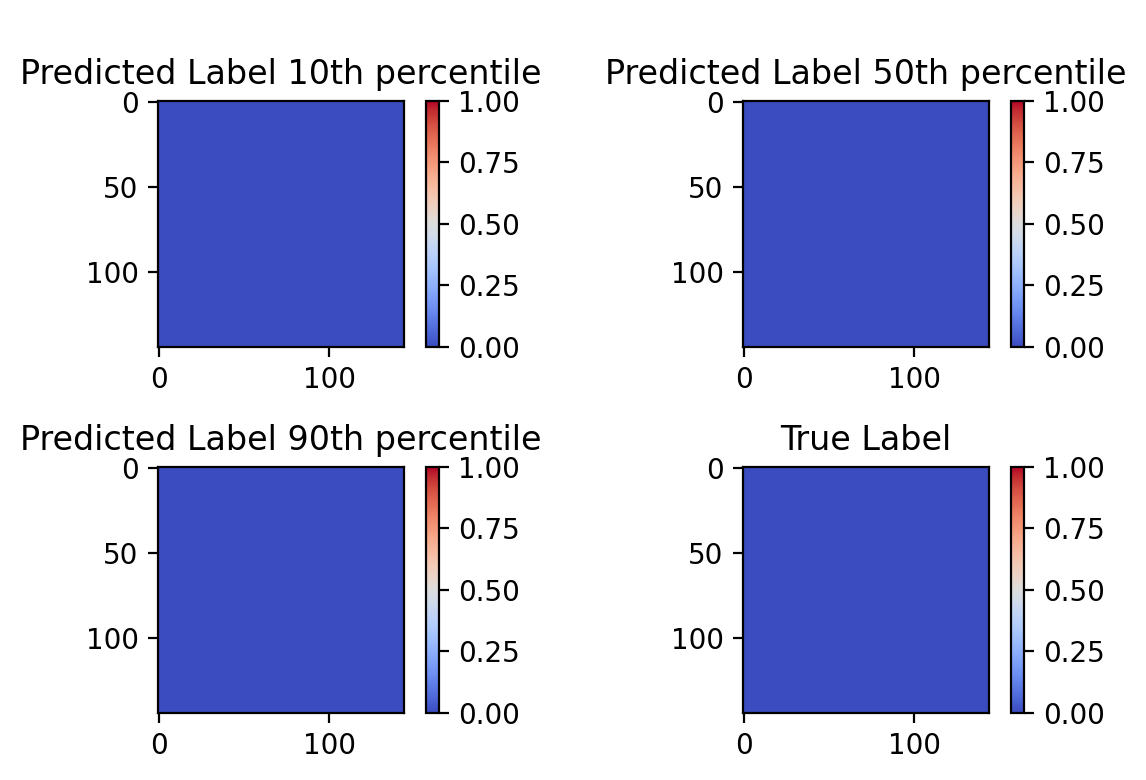

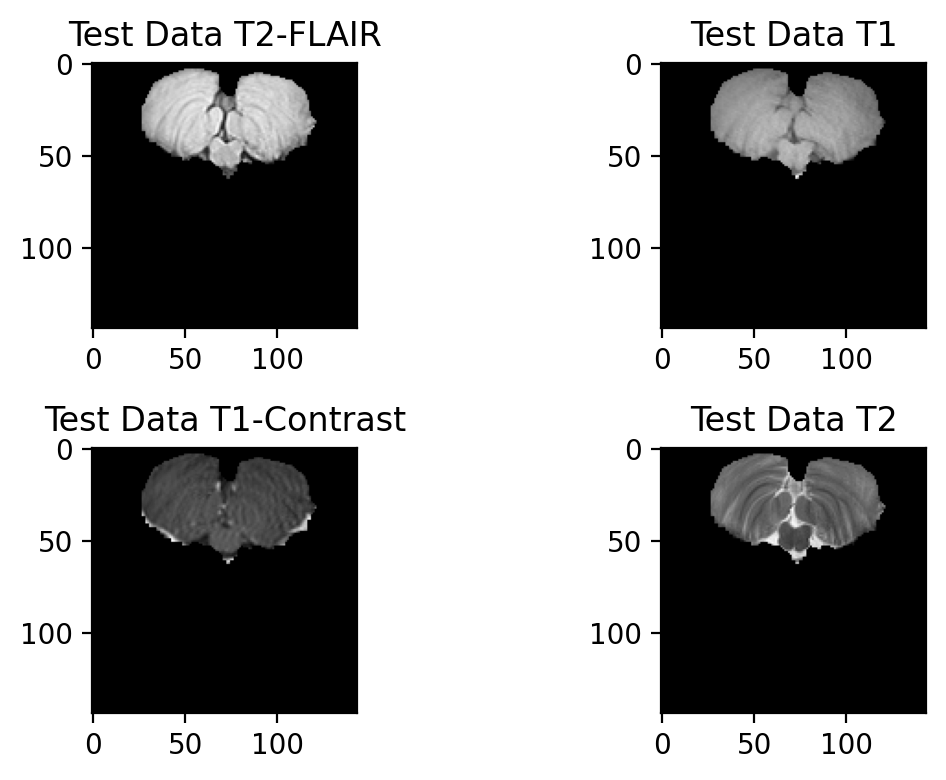

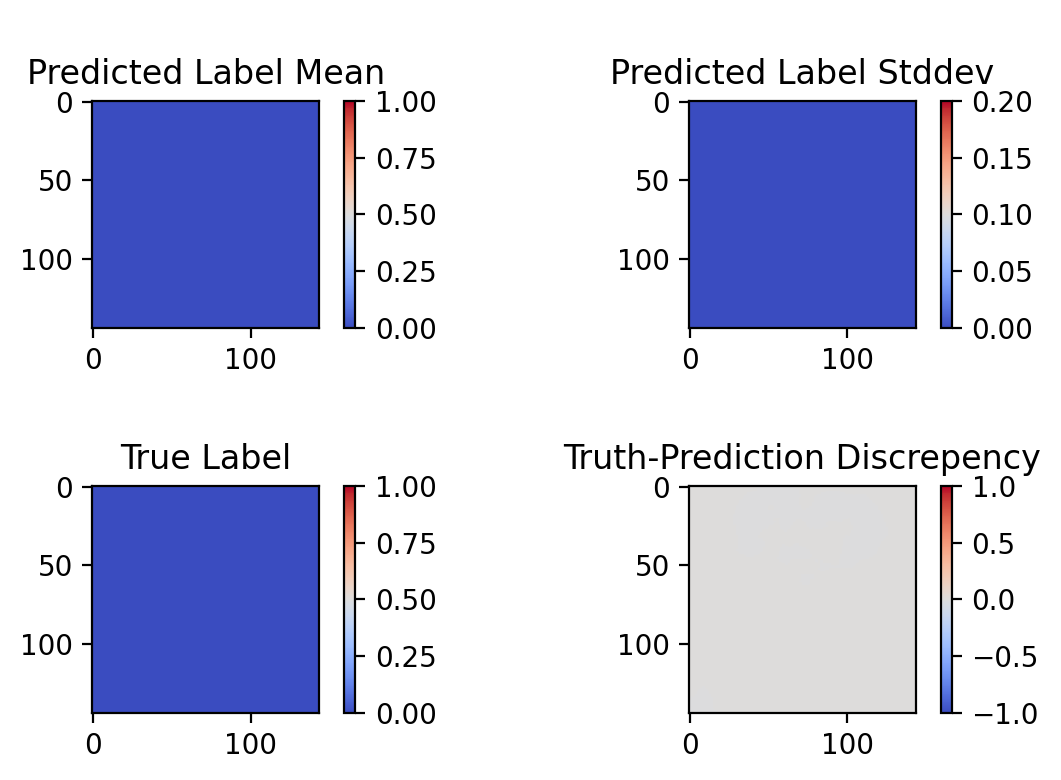

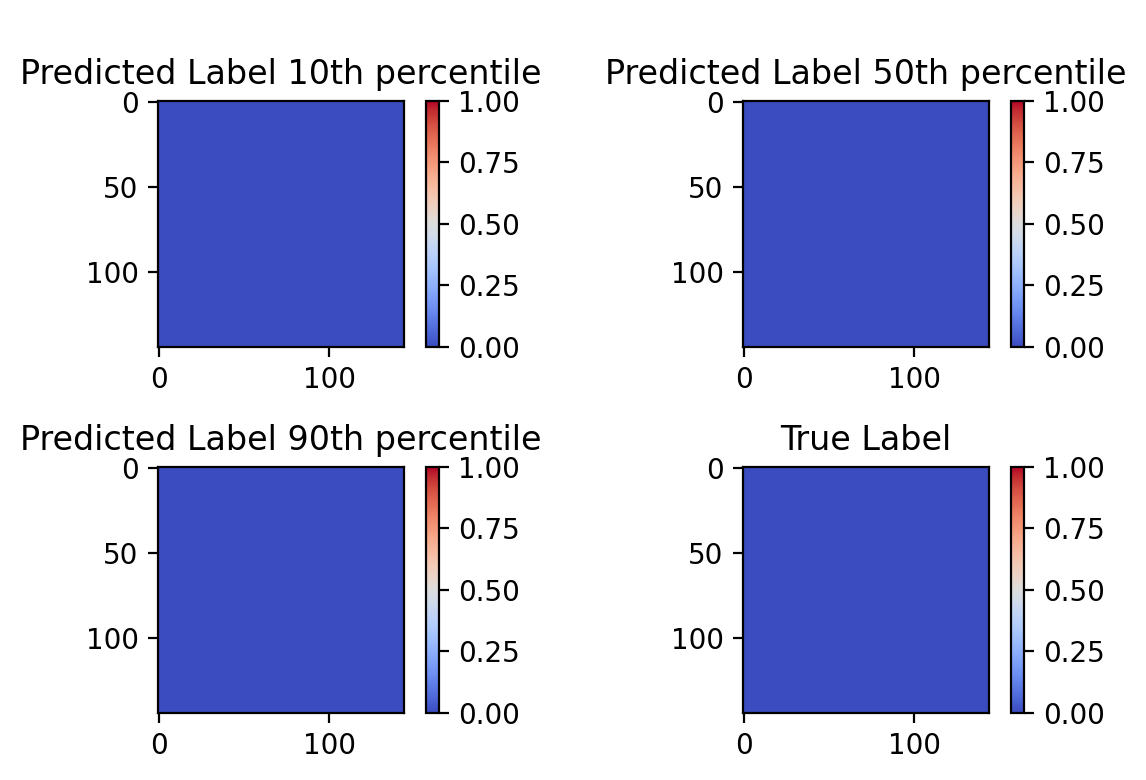

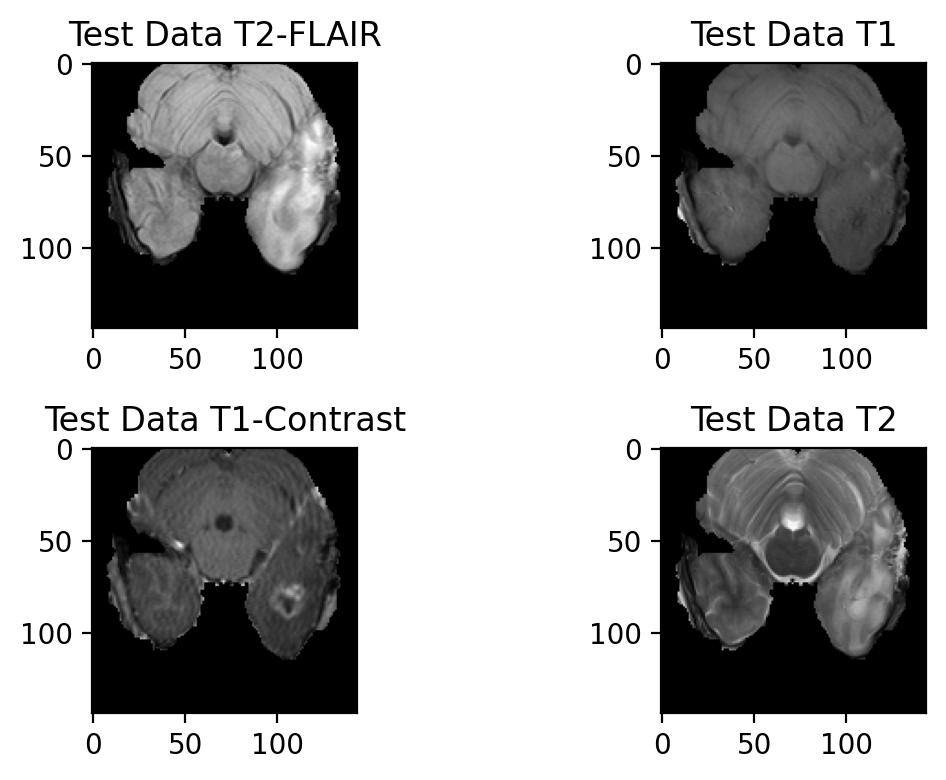

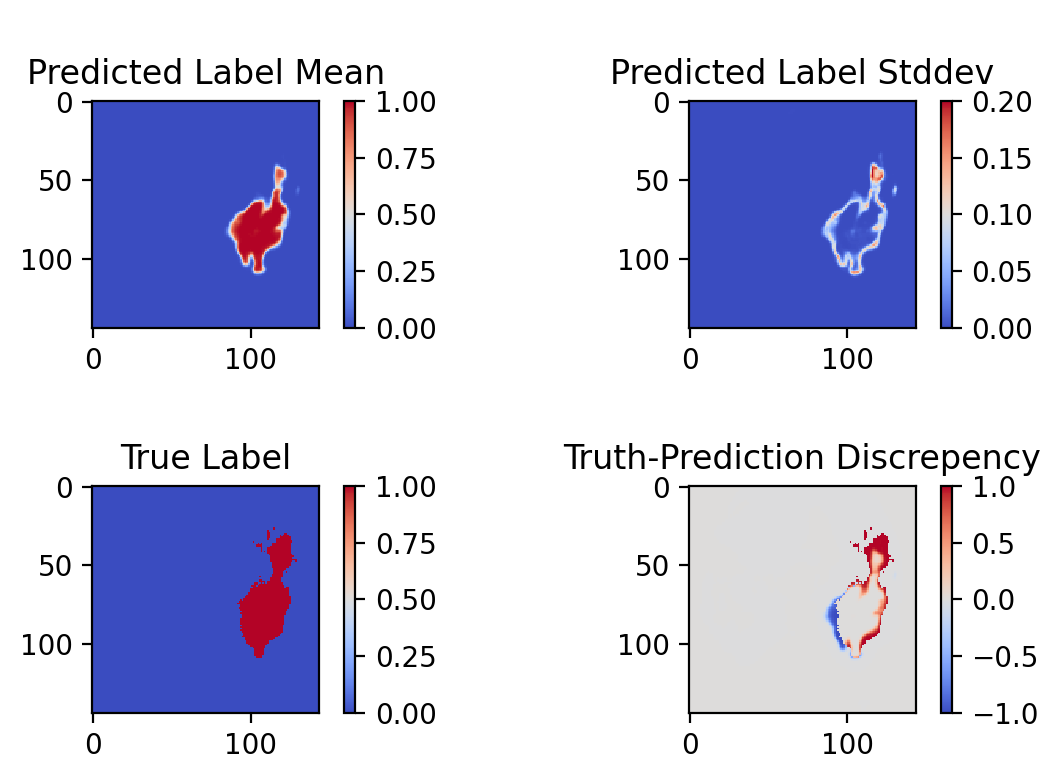

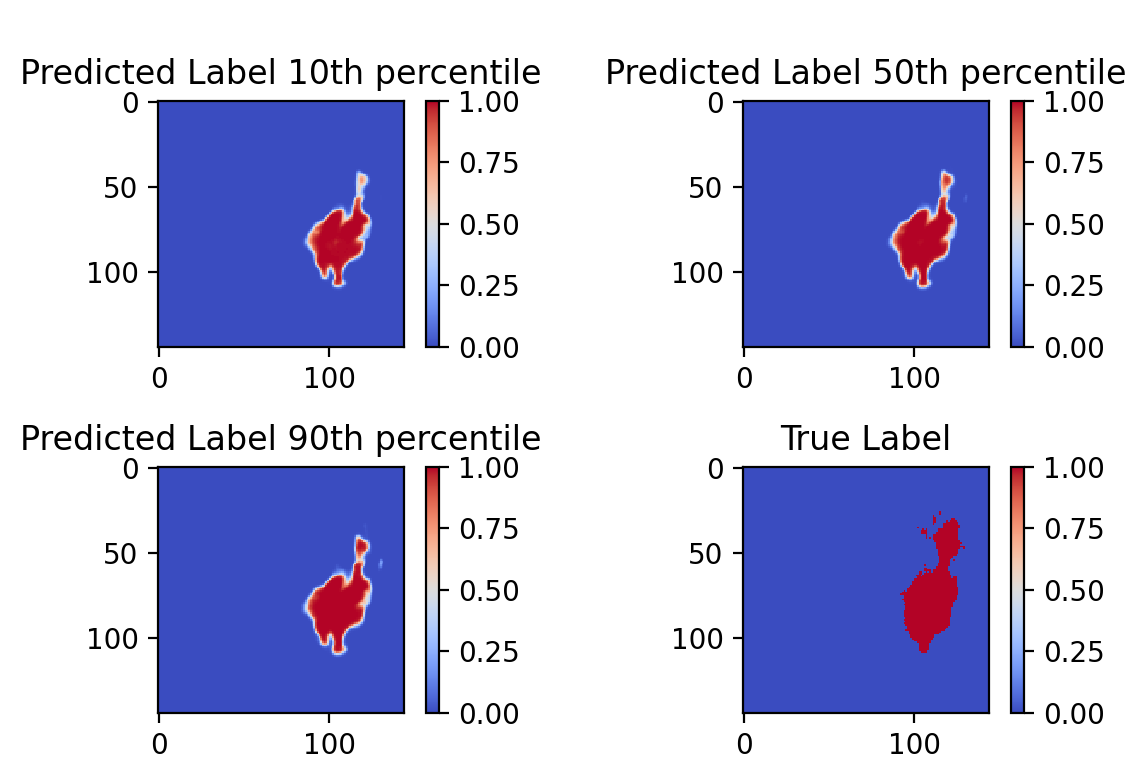

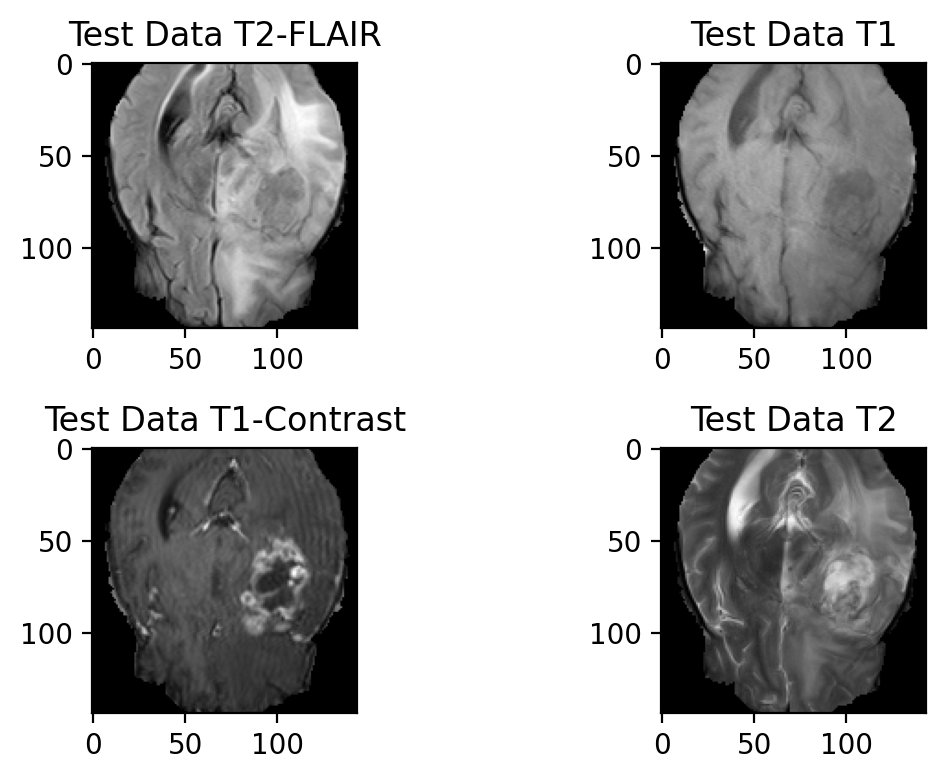

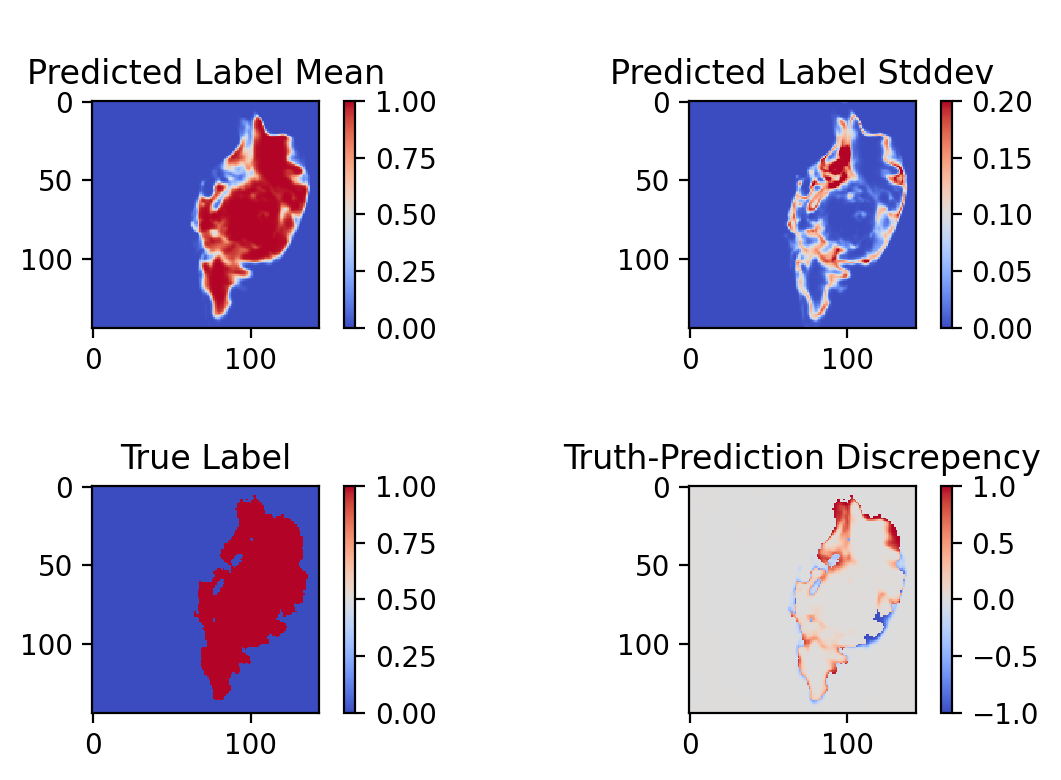

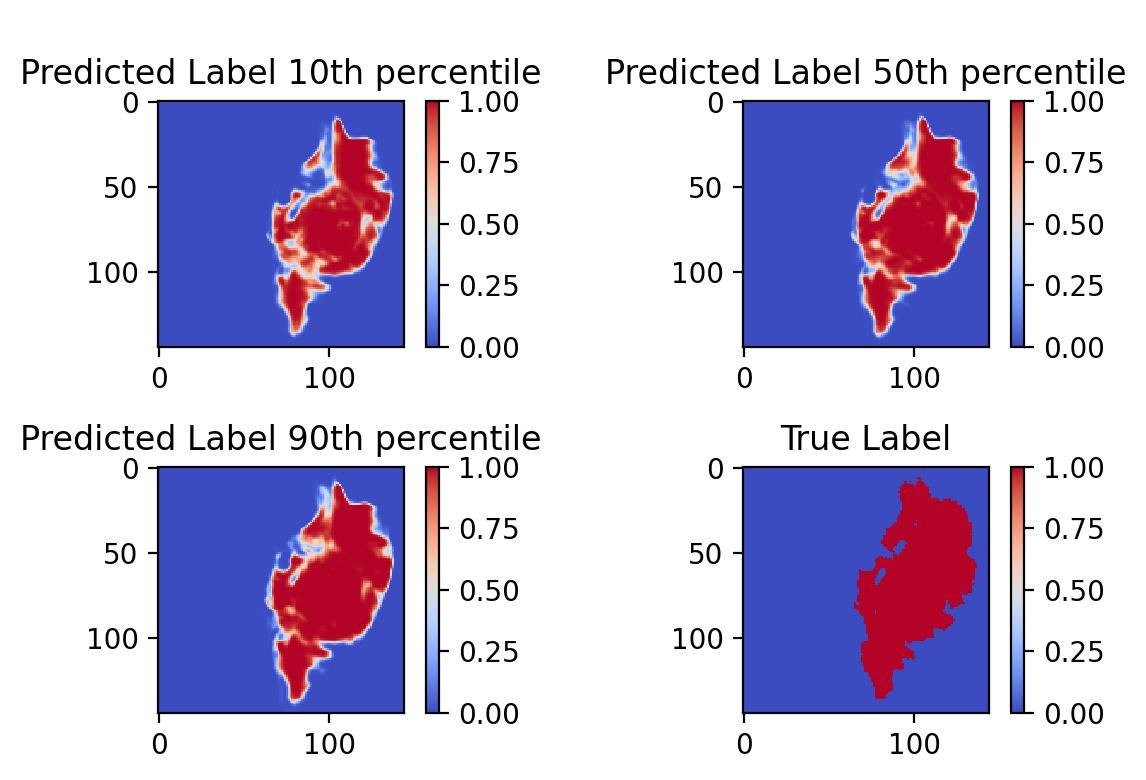

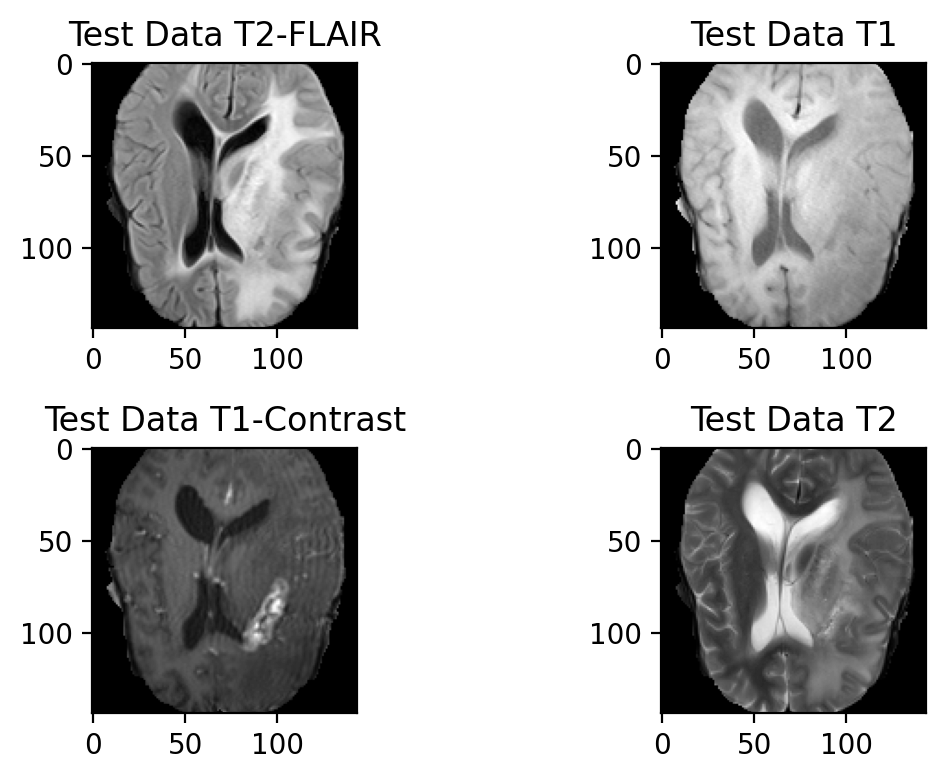

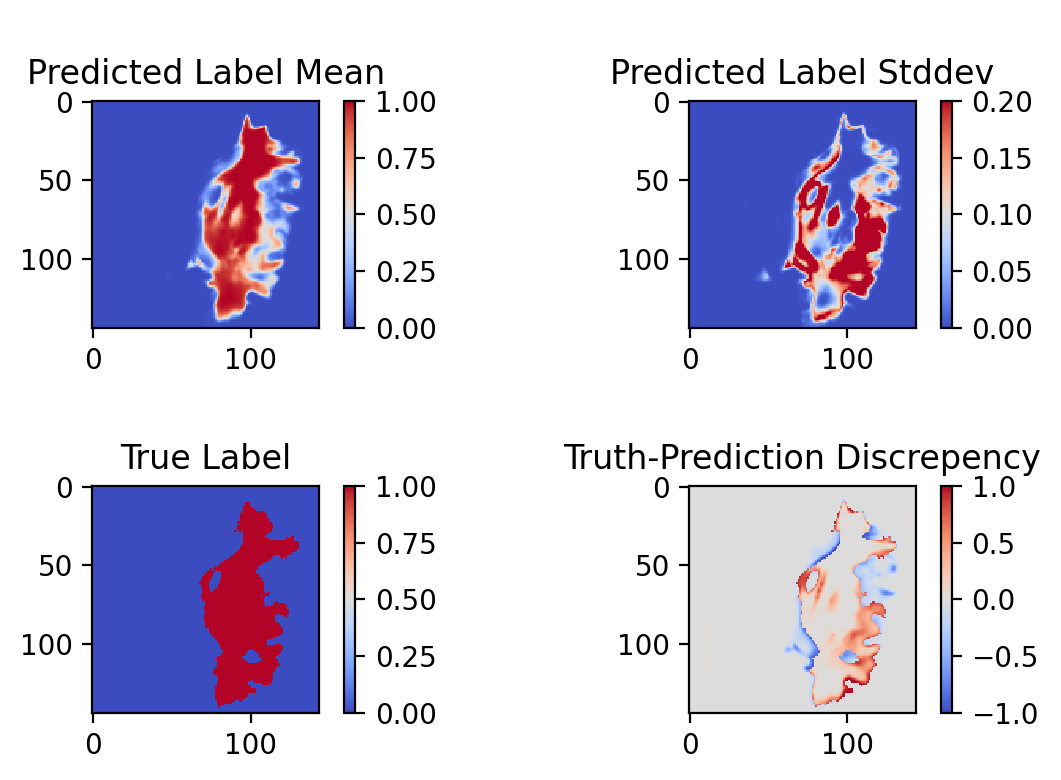

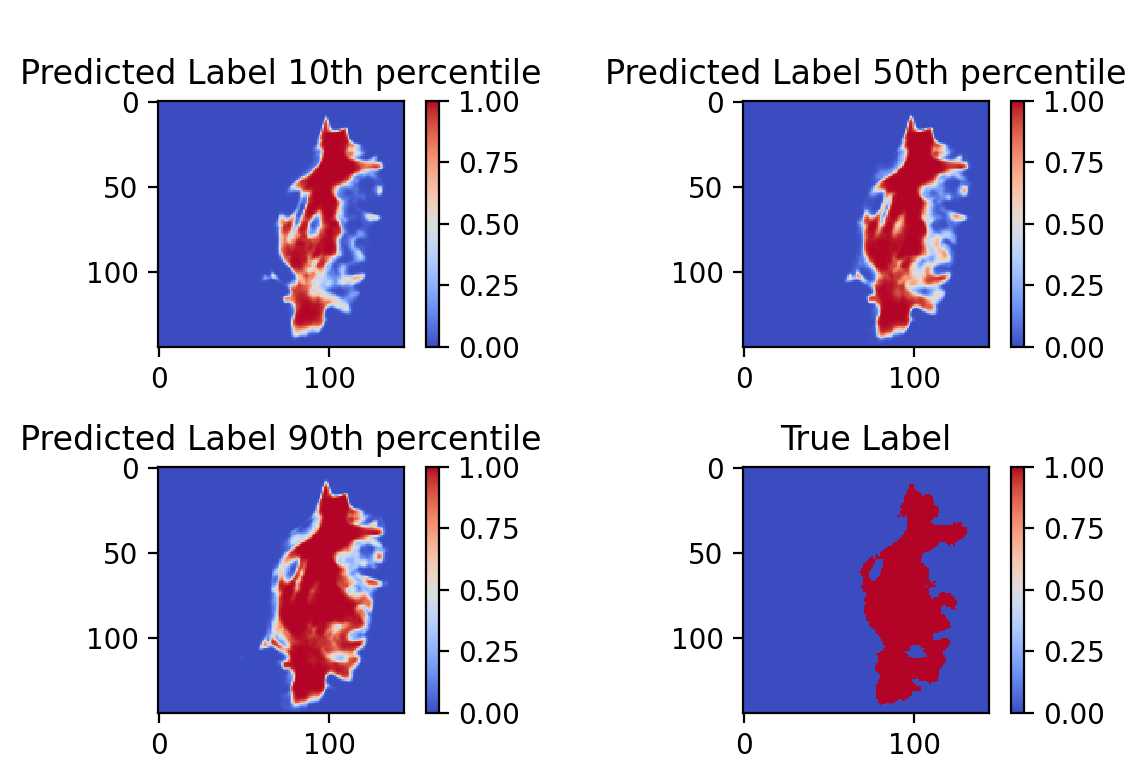

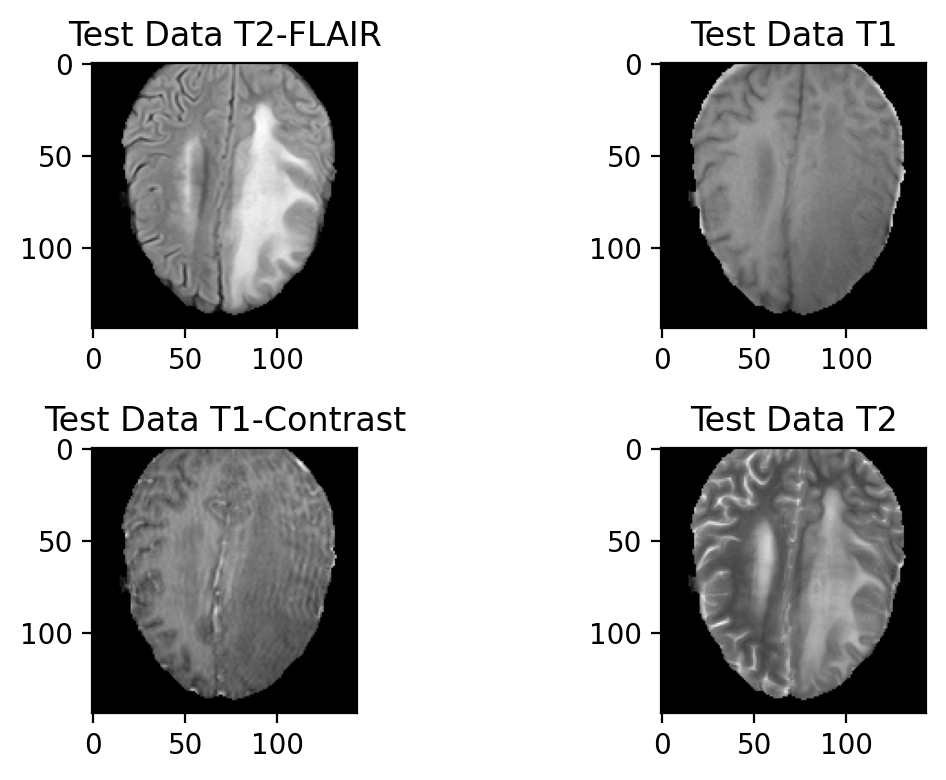

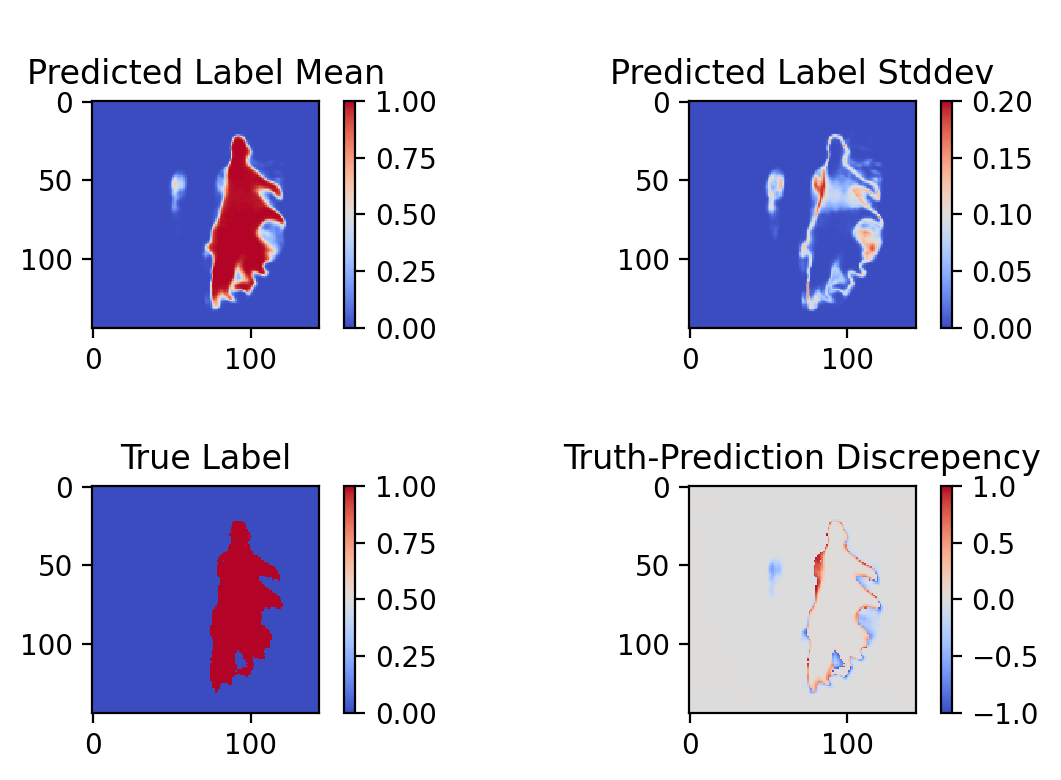

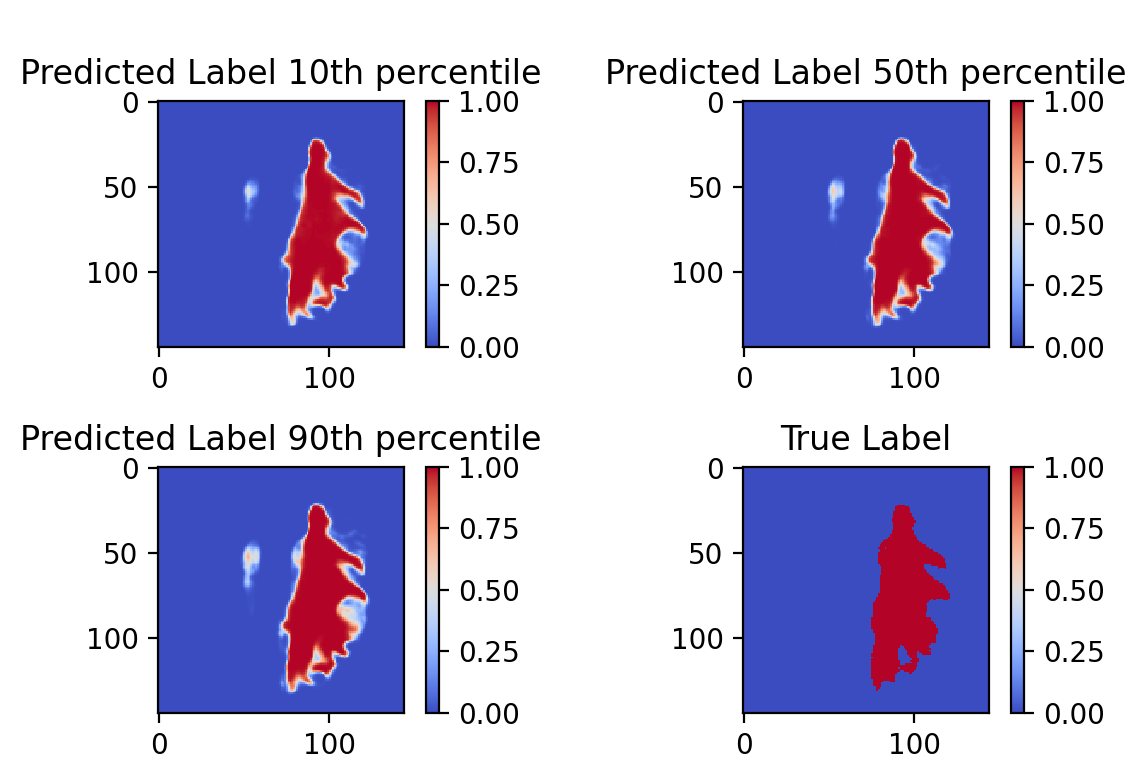

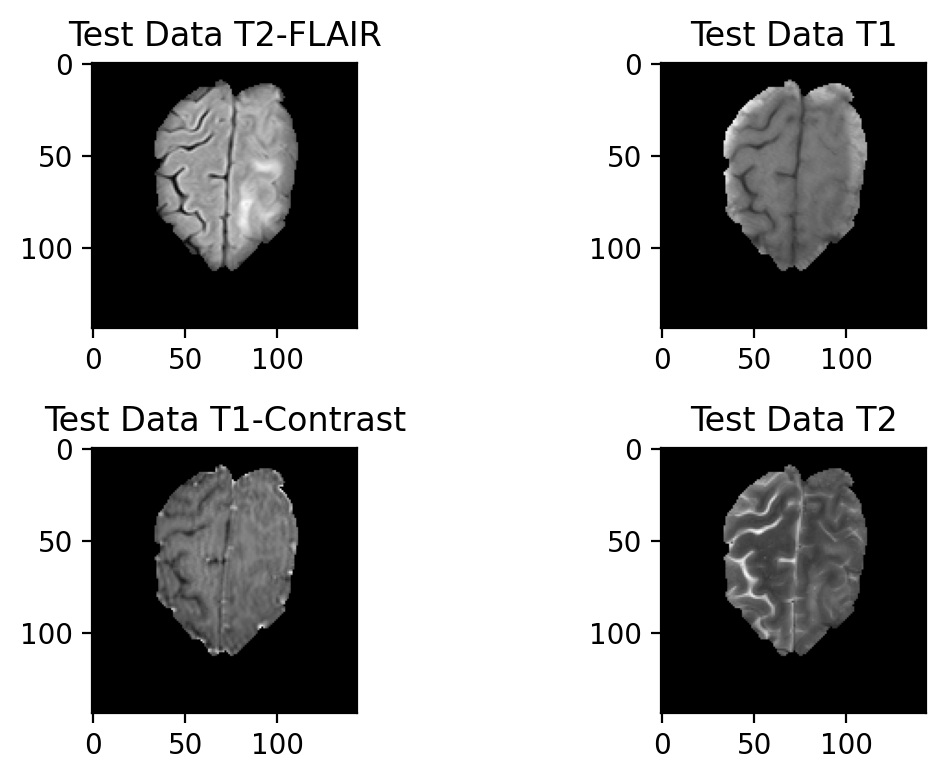

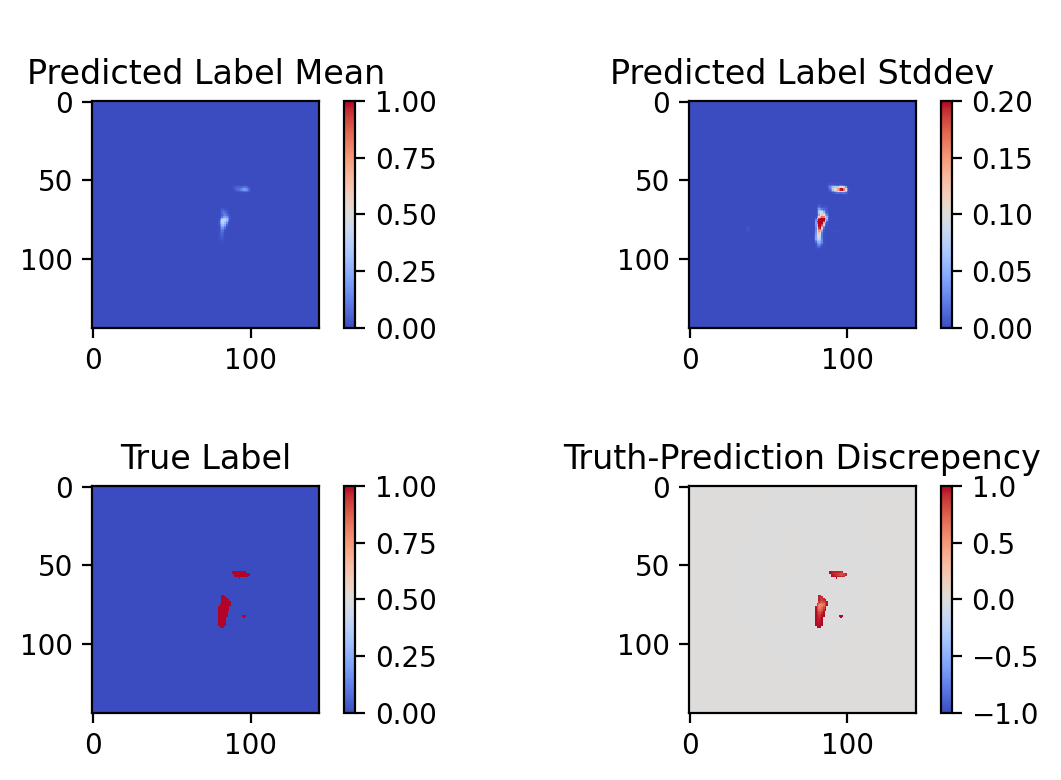

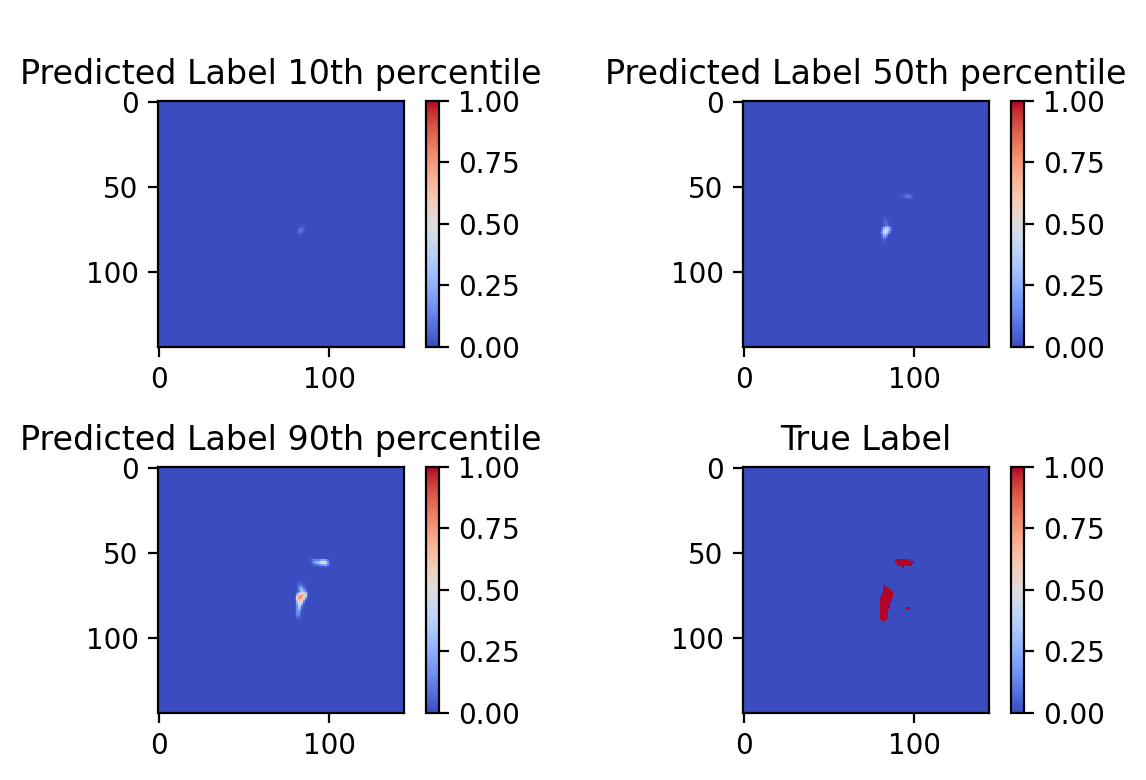

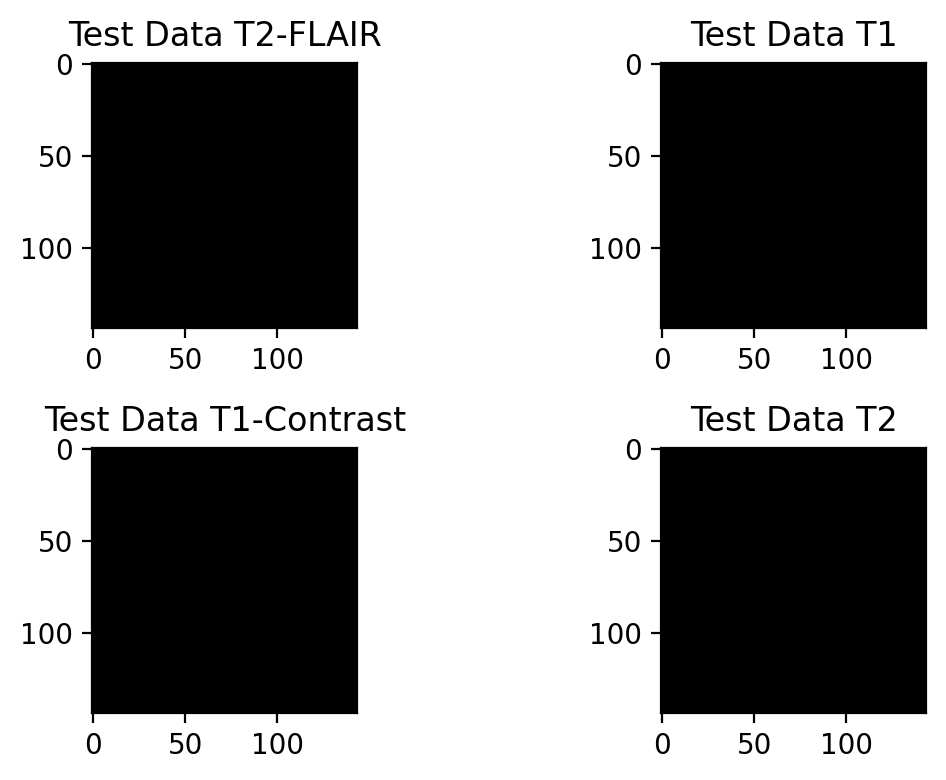

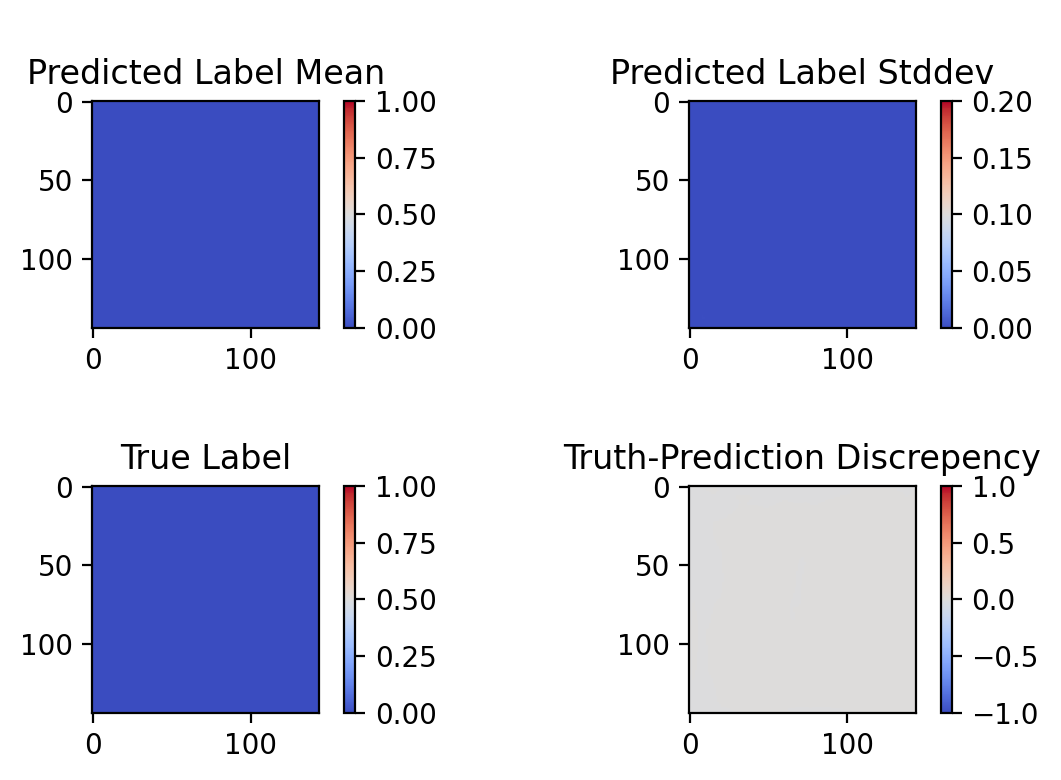

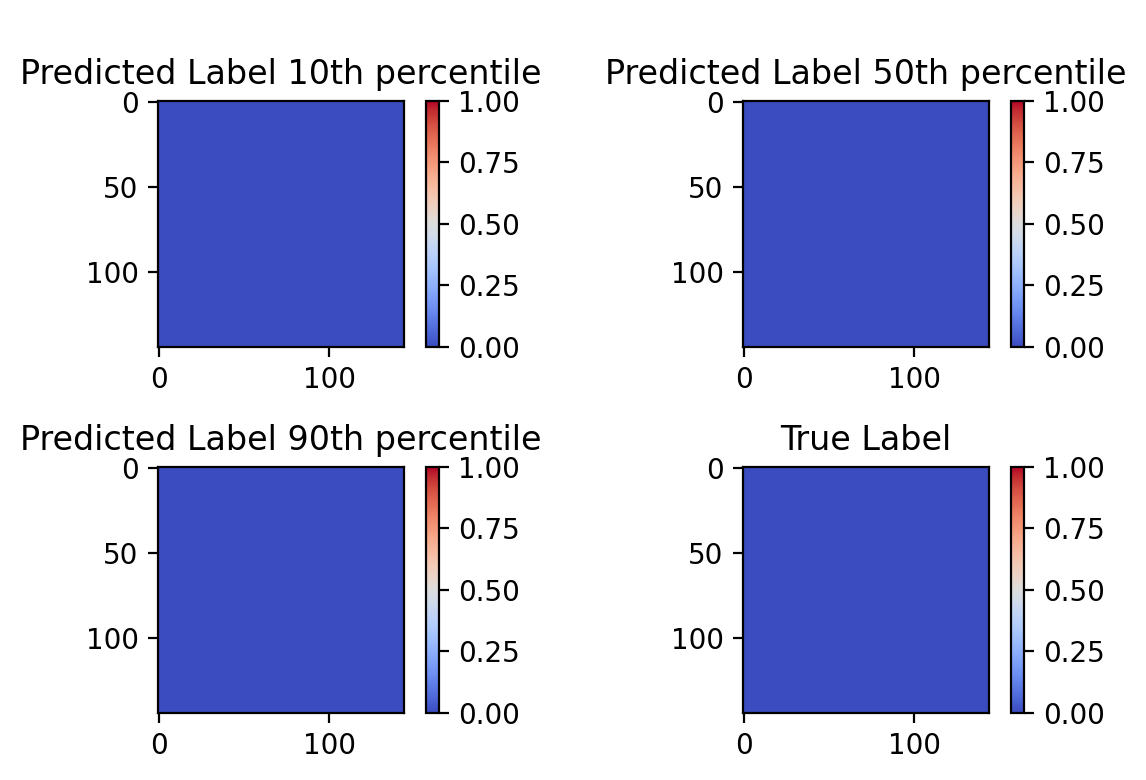

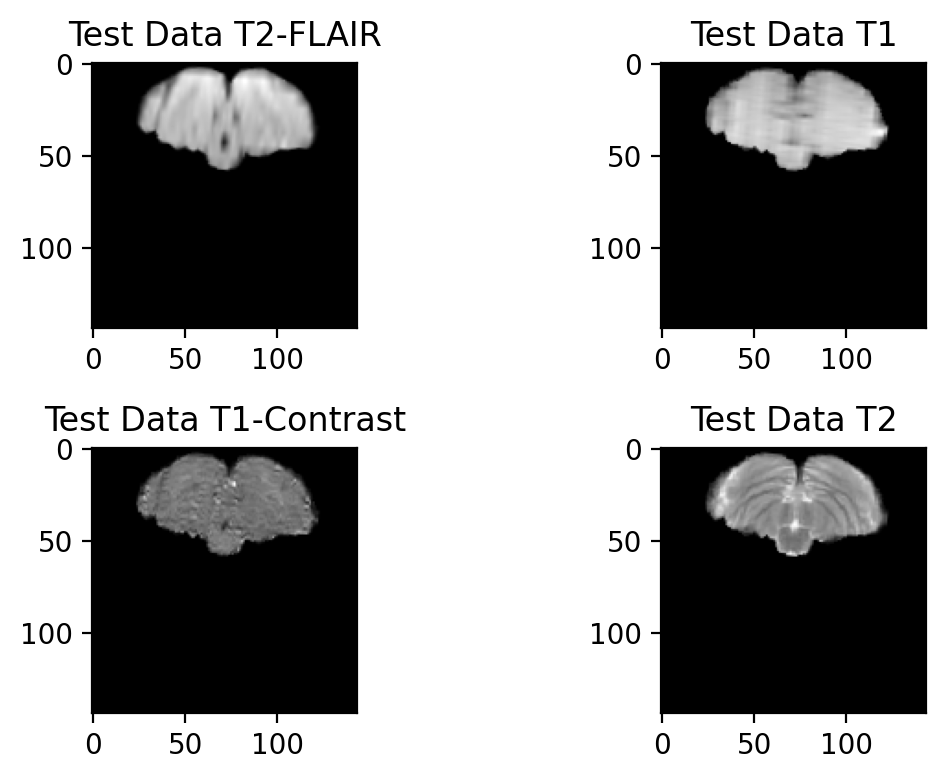

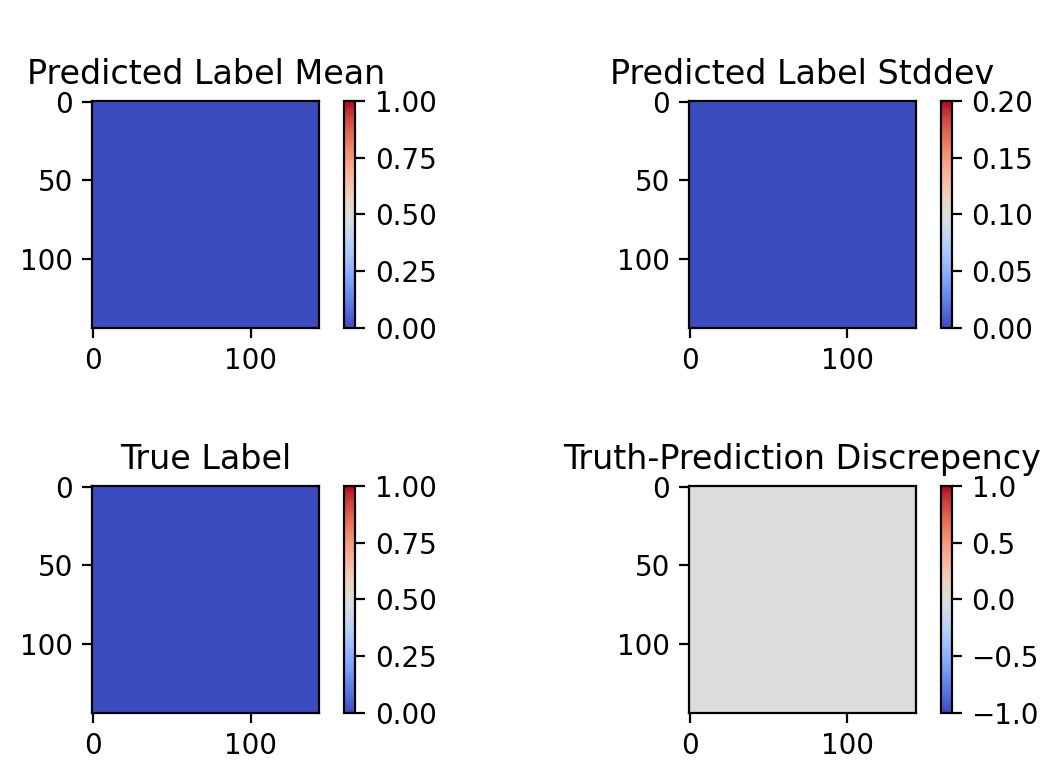

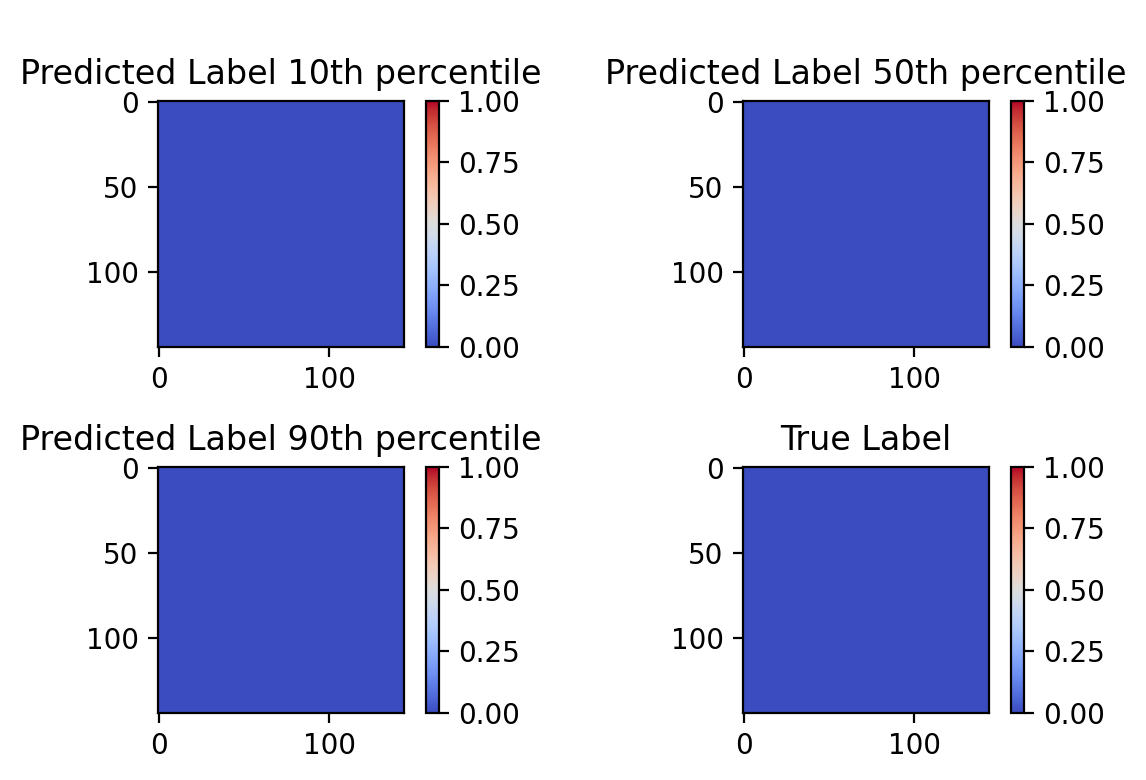

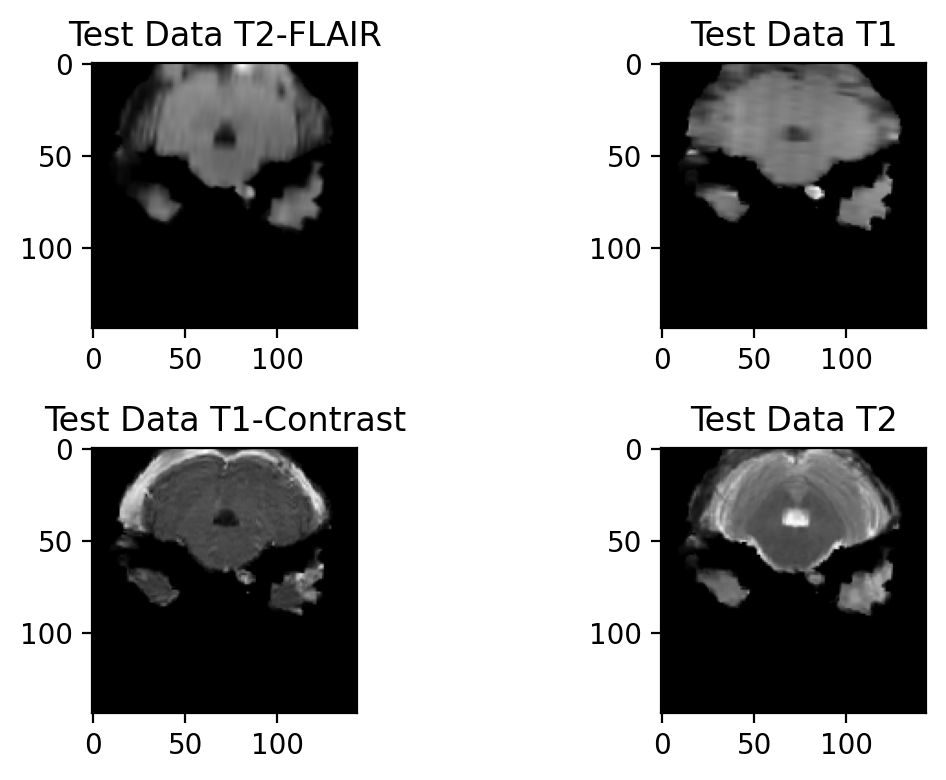

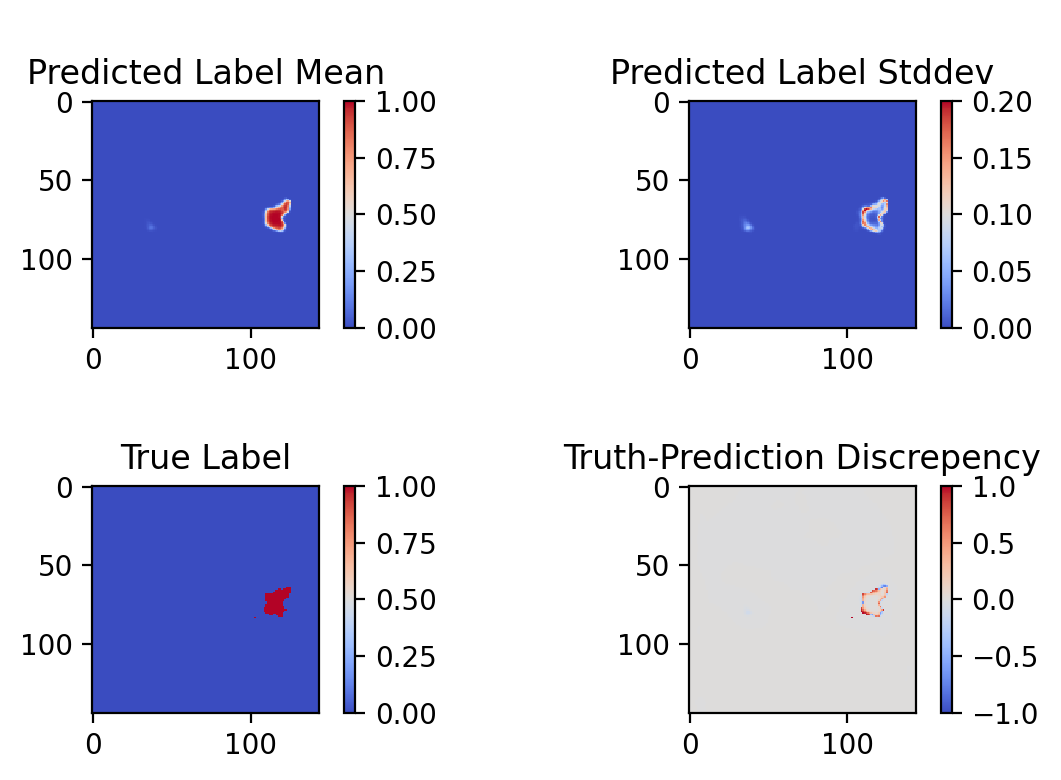

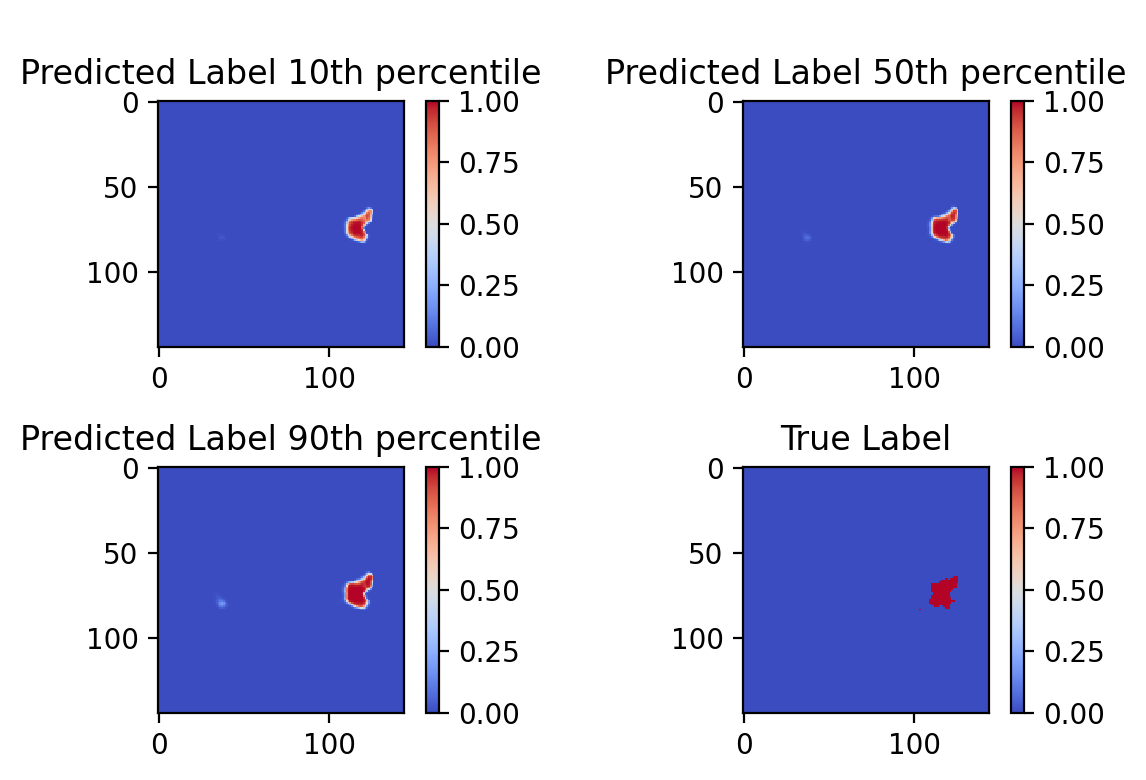

In [83]:
for i in trange(0, 200, 20):
    plt.figure(dpi=200)
    plt.subplot(221)
    plt.title('Test Data T2-FLAIR')
    plt.imshow(imgs_test[i, :, :, 0], cmap='gray')

    plt.subplot(222)
    plt.title('Test Data T1')
    plt.imshow(imgs_test[i, :, :, 1], cmap='gray')

    plt.subplot(223)
    plt.title('Test Data T1-Contrast')
    plt.imshow(imgs_test[i, :, :, 2], cmap='gray')

    plt.subplot(224)
    plt.title('Test Data T2')
    plt.imshow(imgs_test[i, :, :, 3], cmap='gray')
    plt.tight_layout()
    plt.savefig(IMAGE_PATH +  'input_images_'+str(i).zfill(4)+'.png')

    plt.figure(dpi=200)

    plt.subplot(221)
    plt.title('\nPredicted Label Mean')
    plt.imshow(prediction_test.mean(0)[i, :, :, 0], interpolation='nearest')
    plt.colorbar()
    plt.clim(0, 1)

    plt.subplot(222)
    plt.title('\nPredicted Label Stddev')
    plt.imshow(prediction_test.std(0)[i, :, :, 0], interpolation='nearest')
    plt.clim(0, 0.2)
    plt.colorbar()

    plt.subplot(223)
    plt.title('True Label')
    plt.imshow(msks_test[i, :, :, 0], interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()
    
    plt.subplot(224)
    plt.title('\nTruth-Prediction Discrepency')
    plt.imshow((msks_test[i, :, :, 0] - prediction_test.mean(0)[i, :, :, 0]), 
               interpolation='nearest')
    plt.clim(-1, 1)
    plt.colorbar()


    plt.tight_layout()

    plt.savefig(IMAGE_PATH + 'prediction_images_'+str(i).zfill(4)+'.png')


    plt.figure(dpi=200)

    plt.subplot(221)
    plt.title('\nPredicted Label 10th percentile')
    plt.imshow(np.percentile(prediction_test[:, i, :, :, 0], 10, axis=0), interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.subplot(222)
    plt.title('\nPredicted Label 50th percentile')
    plt.imshow(np.percentile(prediction_test[:, i, :, :, 0], 50, axis=0), interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.subplot(223)
    plt.title('Predicted Label 90th percentile')
    plt.imshow(np.percentile(prediction_test[:, i, :, :, 0], 90, axis=0), interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.subplot(224)
    plt.title('True Label')
    plt.imshow(msks_test[i, :, :, 0], interpolation='nearest')
    plt.clim(0, 1)
    plt.colorbar()

    plt.tight_layout()
    plt.savefig(IMAGE_PATH + 'prediction_percentile_images_' + str(i).zfill(4)+'.png')

In [19]:
history = pickle.load(open(PICKLE_PATH, 'rb'))

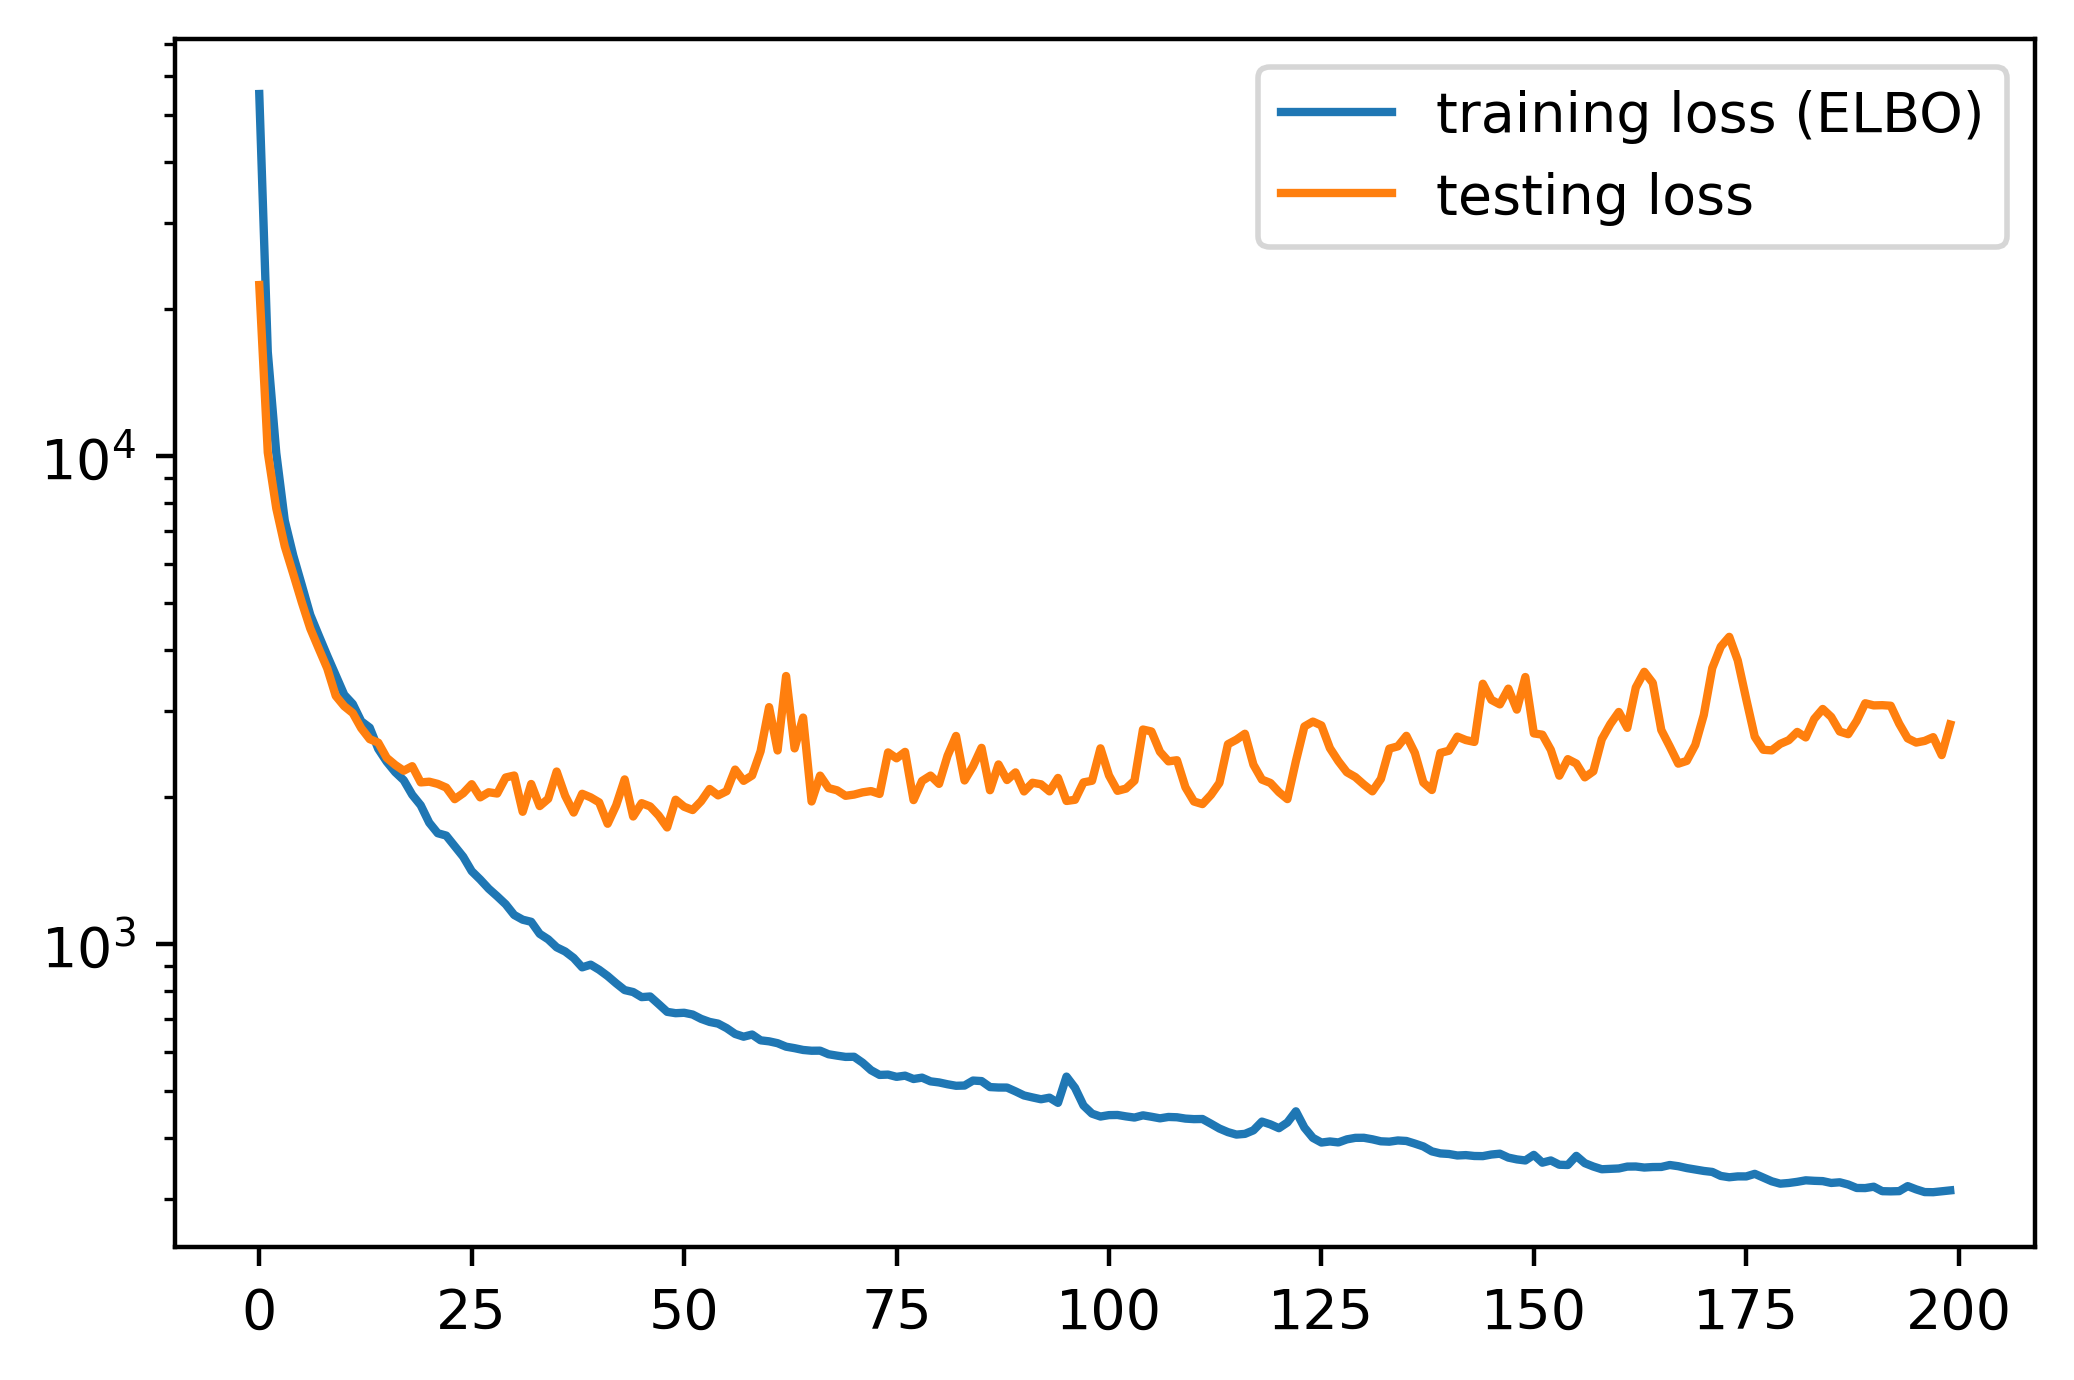

In [20]:
plt.figure(dpi=400)
plt.semilogy(history['loss'], label='training loss (ELBO)')
plt.semilogy(history['val_loss'], label='testing loss')
plt.legend()
plt.savefig(IMAGE_PATH + 'training_history.png')

In [21]:
for layer in model.layers:
    print(layer)
    weights = layer.get_weights()
    for w in weights:
        print(w.shape)

(3, 3, 4, 32)
(3, 3, 4, 32)
(3, 3, 4, 32)
(3, 3, 4, 32)
(32,)
(32,)
(32,)
(32,)
(3, 3, 32, 32)
(32,)
(3, 3, 32, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(3, 3, 128, 256)
(256,)
(3, 3, 256, 256)
(256,)
(3, 3, 256, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 768, 256)
(256,)
(3, 3, 256, 256)
(256,)
(3, 3, 384, 128)
(128,)
(3, 3, 128, 128)
(128,)
(3, 3, 192, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 96, 32)
(32,)
(3, 3, 32, 32)
(32,)
(1, 1, 32, 1)
(1,)


In [34]:
np.int()

0

In [50]:
np.array(0.50).round()

0.0

In [71]:
(msks_test[i, :, :, 0] - prediction_test.mean(0)[i, :, :, 0]).min()

-0.934336063861847

In [70]:
(msks_test[i, :, :, 0] - prediction_test.mean(0)[i, :, :, 0]).max()

0.9711931715909304

In [ ]:
msks_test = np.load(DATA_PATH + 'msks_test.npy')[:n_test]
imgs_test = np.load(DATA_PATH + 'imgs_test.npy')[:n_test]

In [84]:
np.save('imgs_test.npy', imgs_test)
np.save('msms_test.npy', msks_test)